In [13]:
def get_CDOM(ds, lambd=300):
    
    ds=ds.where(ds>0)
    
    if lambd==300:
        alpha = -.0206
        beta = -.6128
        gamma = -.007
        delta = -.4944
        epsilon = .9362
        zeta = .9666
        
    elif lambd==355:
        alpha = .0376
        beta = -.8714
        gamma = -.0352
        delta = -.2739
        epsilon = .9591
        zeta = -.1071
    else:
        print('alg not defined gor lambda={}'.format(lamdb))
        return
        
        
    aCDOM = np.exp(alpha * np.log(ds.Rrs_443.where(ds.Rrs_443>=0)) +
                  beta * np.log(ds.Rrs_488.where(ds.Rrs_488>=0)) +
                  gamma * np.log(ds.Rrs_531.where(ds.Rrs_531>=0)) +
                  delta * np.log(ds.Rrs_555.where(ds.Rrs_555>=0)) +
                  epsilon * np.log(ds.Rrs_667.where(ds.Rrs_667>=0)) + zeta)
    
    return aCDOM

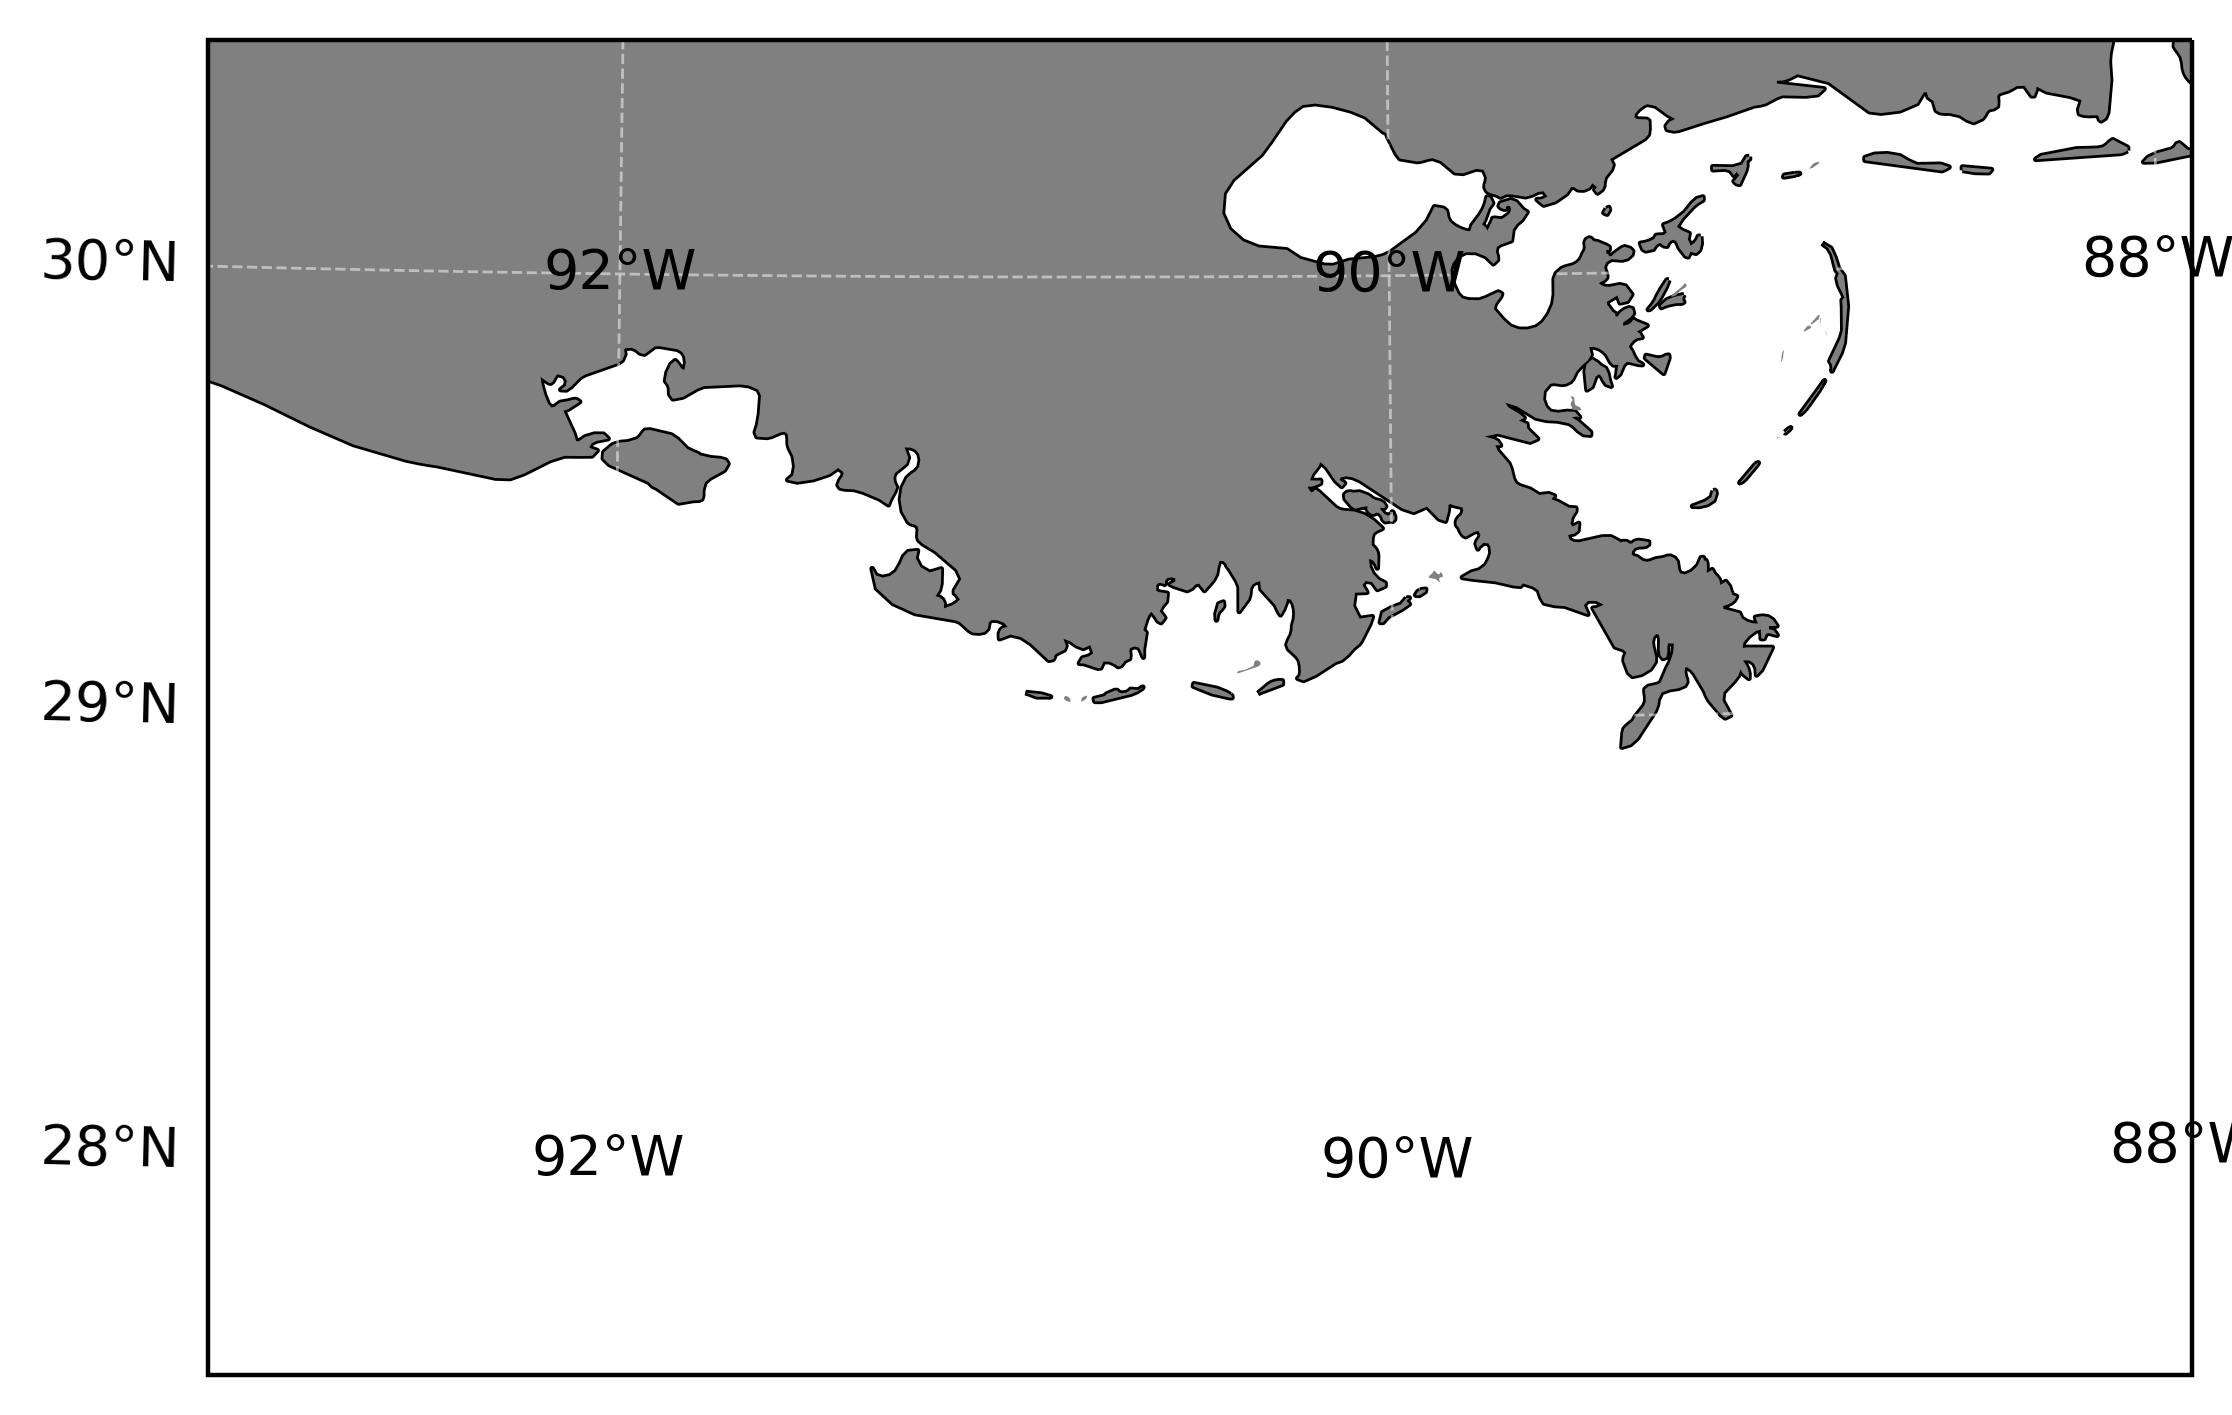

In [38]:
from satpy import Scene, find_files_and_readers
from pyresample import create_area_def
from satpy.writers import get_enhanced_image
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from celluloid import Camera
from satpy import MultiScene
from satpy.multiscene import timeseries
from satpy import Scene, find_files_and_readers
from pyresample import create_area_def
from satpy.writers import get_enhanced_image
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from satpy import MultiScene
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

######

lat_0, lon_0 = 28.5, -90.8

lat_top=30.5
lat_bot=27.5
lon_left=-88
lon_rigth=-93



extent=[lon_left, lon_rigth, lat_bot, lat_top]
resval = 1000
res = xr.DataArray(resval, attrs={"units": "meters"})

def plot_mapbase(extent=extent, res='10m', projection=ccrs.PlateCarree(), ax=None):
    if ax is None:
        fig = plt.figure(dpi=400) # set fig size
        ax = fig.add_subplot(111, projection=projection)
    ax.set_extent(extent , crs=ccrs.PlateCarree())
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='grey', # change color here
                                                scale=res))
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                 ylocs=[28, 29, 30], 
                 xlocs=[-94, -92, -90, -88], 
                 draw_labels=True, linewidth=0.5, color='w', alpha=0.5, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    return ax

mapbase = plot_mapbase(projection= ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0))

######
        
        
def TrueColor():
    
    i=0
    base = '/home/hboi-ouri/Downloads/FigureFiles/MYD021KM.'

    #files to be used
    filenames = glob('/home/hboi-ouri/Downloads/FigureFiles/MYD021KM.*')
    swats = np.unique([f.split('.')[1] for f in filenames])
    

    #area in the figure
    extent = [-94, 27.5, -88, 30.5]
    my_area = create_area_def('my_area', {'proj': 'lcc', 'lon_0': -91., 'lat_0': 29.5, 'lat_1': 29.5, 'lat_2': 29.5},
                    width=1500, height=750,
                    area_extent=extent, units='degrees')
        
    fig =  plt.figure(figsize=(6, 4), dpi=400)

    #loop
    for swat in swats:
        dayfiles = glob(base+swat+'*')
        scn = Scene(dayfiles, reader='modis_l1b')
        scn.load(['true_color'])

        #reproject
        new_scn = scn.resample(my_area)

        #generate RGB from true color
        rgb = get_enhanced_image(new_scn['true_color'])

        #extract projection and lon lat from products
        crs = new_scn['true_color'].attrs['area'].to_cartopy_crs()
        lons, lats = new_scn['true_color'].attrs['area'].get_lonlats()

        #left true color
        ax1 = plt.subplot(projection=crs)
        rgb.data.plot.imshow(rgb='bands', transform=crs, ax=ax1)
        
        plot_mapbase(ax=ax1)


        #title & save
        ax1.set_title(new_scn.start_time.isoformat()[0:10], size=15)
#         fig.text(0.035, 0.41, 'Latitude', size=13, rotation=90)
#         fig.text(0.435, 0.025, 'Longitude', size=13)
        fig.savefig('/home/hboi-ouri/Downloads/Output/TC%s_rgb.png' 
          % (new_scn.start_time.isoformat()[0:10]))
        fig.clear()

        
A = 0.472; B = 1.48; C = 4.64

        
def aCDOM():
    
    i=0
    base = '/home/hboi-ouri/Downloads/FigureFiles/MYD021KM.'

    #files to be used
    filenames = glob('/home/hboi-ouri/Downloads/FigureFiles/MYD021KM.*')
    swats = np.unique([f.split('.')[1] for f in filenames])
    

    #area in the figure
    extent = [-94, 27.5, -88, 30.5]
    my_area = create_area_def('my_area', {'proj': 'lcc', 'lon_0': -91., 'lat_0': 29.5, 'lat_1': 29.5, 'lat_2': 29.5},
                    width=1500, height=750,
                    area_extent=extent, units='degrees')
        
    fig =  plt.figure(figsize=(6, 4), dpi=400)

    #loop
    for swat in swats:
        dayfiles = glob(base+swat+'*')
        scn = Scene(dayfiles, reader='modis_l1b')
        scn.load(['10','4'])
        scn.load(['true_color'])


        #reproject
        new_scn = scn.resample(my_area)

        #generate RGB from true color
        aCDOM412 = (np.log((new_scn['10']/new_scn['4'] - A)/ B))/(-C)
        aCDOM412 = aCDOM412.compute()
        #extract projection and lon lat from products
        crs = new_scn['true_color'].attrs['area'].to_cartopy_crs()
        lons, lats = new_scn['true_color'].attrs['area'].get_lonlats()

        #left true color
        trim = aCDOM412.max().values
        ax1 = plt.subplot(projection=crs)
        #this is ploting x,y, aCDOM
        im = ax1.pcolormesh(lons, lats, aCDOM412.where(aCDOM412<=trim), transform=ccrs.PlateCarree(),
                      vmin=.01, vmax=.3)

        

        plot_mapbase(ax=ax1)
        fig.colorbar(im, orientation='horizontal')


        #title & save
        ax1.set_title(new_scn.start_time.isoformat()[0:10], fontsize=15)
#         fig.text(0.035, 0.41, 'Latitude', size=13, rotation=90)
#         fig.text(0.435, 0.025, 'Longitude', size=13)
        fig.savefig('/home/hboi-ouri/Downloads/Output/aCDOM%s_rgb.png' 
          % (new_scn.start_time.isoformat()[0:10]))
        fig.clear()
        
        
        
                
def BaCDOM():
    
    i=0
    base = '/home/hboi-ouri/Downloads/MeanFigureFiles/After/CombinedaCDOM/'

    #files to be used
    #filenames = glob('/home/hboi-ouri/Downloads/MeanFigureFiles/Before/CombinedaCDOM/*_MODIS_L2_aCDOM.nc')

    filenames = glob('/home/hboi-ouri/Downloads/MeanFigureFiles/After/CombinedaCDOM/*_MODIS_L2.nc')
    

    #area in the figure
    extent = [-94, 27.5, -88, 30.5]
    my_area = create_area_def('my_area', {'proj': 'lcc', 'lon_0': -91., 'lat_0': 29.5, 'lat_1': 29.5, 'lat_2': 29.5},
                    width=1500, height=750,
                    area_extent=extent, units='degrees')
        
    fig =  plt.figure(figsize=(6, 4), dpi=400)

    #loop
    for swat in filenames:


        #reproject

        ds = xr.open_dataset(swat)
        #data = ds.acdom
        data = ds.acdom.mean('time')
        ax1 = plt.subplot(projection=ccrs.PlateCarree())

        #im = axgr[i].imshow(data, extent=extent, vmin=0, vmax=5)
        im = data.where(data!=0).plot(ax=ax1, vmin=0, vmax=10, x='lon', y='lat', add_colorbar=False) #transform=projection)
        #extract projection and lon lat from products


        #left true color
#         data.plot.imshow(rgb='bands', transform=crs, ax=ax1)
        
        plot_mapbase(ax=ax1)


        #title & save
        #ax1.set_title(new_scn.start_time.isoformat()[0:10], size=15)
#         fig.text(0.035, 0.41, 'Latitude', size=13, rotation=90)
#         fig.text(0.435, 0.025, 'Longitude', size=13)
#         fig.savefig('/home/hboi-ouri/Downloads/Output/BaCDOMMeanBefore%s_rgb.png' 
#           % (swat.split('/')[5][0:8]))
        fig.savefig('/home/hboi-ouri/Downloads/Output/BaCDOMMeanAfter_rgb.png')
        fig.clear()



In [39]:
BaCDOM()

<Figure size 2400x1600 with 0 Axes>

In [68]:
def get_CDOM(ds, lambd=300):
    
    ds=ds.where(ds>0)
    
    if lambd==300:
        alpha = -.0206
        beta = -.6128
        gamma = -.007
        delta = -.4944
        epsilon = .9362
        zeta = .9666
        
    elif lambd==355:
        alpha = .0376
        beta = -.8714
        gamma = -.0352
        delta = -.2739
        epsilon = .9591
        zeta = -.1071
    else:
        print('alg not defined gor lambda={}'.format(lamdb))
        return
        
        
    aCDOM = np.exp(alpha * np.log(ds.Rrs_443.where(ds.Rrs_443>=0)) +
                  beta * np.log(ds.Rrs_488.where(ds.Rrs_488>=0)) +
                  gamma * np.log(ds.Rrs_531.where(ds.Rrs_531>=0)) +
                  delta * np.log(ds.Rrs_555.where(ds.Rrs_555>=0)) +
                  epsilon * np.log(ds.Rrs_667.where(ds.Rrs_667>=0)) + zeta)
    
    return aCDOM


with xr.open_dataset(scn) as ds:
        data = ds.load()
        data['acdom'] =get_CDOM(ds)

NameError: name 'scn' is not defined

In [2]:
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np
from pyresample import geometry, create_area_def
from satpy import Scene

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

combfiles = glob('/home/hboi-ouri/Downloads/FigureFiles/*')
combfiles.sort()

for file in combfiles:

    with xr.open_dataset(file) as ds:
        data = ds.load()
        data['acdom'] =get_CDOM(ds)
        
        ##for naming and saving the file:
        #date = [file.split('/')[9]]
        #year = ((date[0])[0:4])
        #month = ((date[0])[5:7])
        
        date = [file.split('_')[2]]
        storm = ((date[0]))
    
        #data.to_netcdf(file[0:66] + '2010ResaCDOM' + file[72:-12] + '_MODIS_L2_aCDOM.nc')
        #data.to_netcdf('/home/hboi-ouri/Projects/RS_Files/MODISGrids/CombinedMODIS/CruiseaCDOM/' + storm + 'Res_MODIS_L2_aCDOM.nc')
        #data.to_netcdf('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/2012aCDOM/' + year + '_' + month + '_MODIS_L2_aCDOM.nc')
        #data.to_netcdf(file[0:59] + '2012ResaCDOM/' + file[67:-12] + '_MODIS_L2_aCDOM.nc')
        data.to_hdf('/home/hboi-ouri/Downloads/aCDOMFigureFiles/%s.hdf' % file.start_time.isoformat()[0:10])

    
    
    



ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'cfgrib', 'pydap', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

# For Combined File

In [2]:
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np
from pyresample import geometry, create_area_def
from satpy import Scene

In [16]:
files = glob('/home/hboi-ouri/Downloads/MeanFigureFiles/After/*AQUA_MODIS.*.L2.OC.x.nc')
files.sort()
files


['/home/hboi-ouri/Downloads/MeanFigureFiles/After/AQUA_MODIS.20201009T191501.L2.OC.x.nc',
 '/home/hboi-ouri/Downloads/MeanFigureFiles/After/AQUA_MODIS.20201010T182001.L2.OC.x.nc',
 '/home/hboi-ouri/Downloads/MeanFigureFiles/After/AQUA_MODIS.20201010T200001.L2.OC.x.nc',
 '/home/hboi-ouri/Downloads/MeanFigureFiles/After/AQUA_MODIS.20201011T190500.L2.OC.x.nc',
 '/home/hboi-ouri/Downloads/MeanFigureFiles/After/AQUA_MODIS.20201012T194501.L2.OC.x.nc',
 '/home/hboi-ouri/Downloads/MeanFigureFiles/After/AQUA_MODIS.20201012T195001.L2.OC.x.nc',
 '/home/hboi-ouri/Downloads/MeanFigureFiles/After/AQUA_MODIS.20201013T185001.L2.OC.x.nc',
 '/home/hboi-ouri/Downloads/MeanFigureFiles/After/AQUA_MODIS.20201013T185501.L2.OC.x.nc',
 '/home/hboi-ouri/Downloads/MeanFigureFiles/After/AQUA_MODIS.20201014T193500.L2.OC.x.nc',
 '/home/hboi-ouri/Downloads/MeanFigureFiles/After/AQUA_MODIS.20201015T184001.L2.OC.x.nc',
 '/home/hboi-ouri/Downloads/MeanFigureFiles/After/AQUA_MODIS.20201015T202001.L2.OC.x.nc',
 '/home/hb

In [17]:
# Functions to be used

def convtoxr(scn, var):
    #convert from dask array
    data = scn[var].load()
    data = data.where(data >= 0)
    data.name = var
    del(data.attrs['_satpy_id']) ### removing, we don't need this.
    data.attrs['area'] = str(data.attrs['area']) ### We may or may not need this in the future so converting it to a string
    return data

def load_satdata(path, 
                 area_deff=None,
                 res=None,
                 name="GOMEX", proj={"proj": "laea"}, area_extent=(-94, 27.5, -88, 30.5),
                ):
#   get data and attributes
    data = xr.open_dataset(path, group='geophysical_data')
    navigation = xr.open_dataset(path, group='navigation_data')
    navigation = navigation.rename({'pixel_control_points': 'pixels_per_line'})
    attrs = xr.open_dataset(path).attrs
    
#   area definition if not defined
    if res is None:
        # get the resolution of the Sat product
        val, unit = attrs['spatialResolution'].split()
        res  = xr.DataArray(float(val), attrs={"units": unit})
    if area_deff is None:
        area_deff = create_area_def(name, proj, area_extent=area_extent, units="degrees", resolution=res)
        
#   reprojecting
    scn = Scene()
    swath_def = geometry.SwathDefinition(lons=navigation.longitude, lats= navigation.latitude)
    vnames = [v for v in data.data_vars if 'Rrs' in v]
    for var in vnames:
        scn[var] = data[var]
        scn[var].attrs["area"] = swath_def
    resampled_scn = scn.resample(area_deff, radius_of_influence=int(res))
    resampled_scn.compute()
    lons, lats = resampled_scn[vnames[0]].attrs['area'].get_lonlats()
#   Converting back to xarray dataset
    ds = xr.merge([convtoxr(resampled_scn, var) for var in vnames])
    ds.attrs = attrs
    ds = ds.assign_coords({
                            'lon': (('y', 'x'), lons),
                            'lat': (('y', 'x'), lats),
                            'time': pd.to_datetime(attrs['time_coverage_start'])
                            })
#   getting rid of the crs coord
    # ds.attrs['crs'] = ds.crs
    ds = ds.drop('crs')
    print(str(ds.time.data))
    return ds


In [18]:
# Area setup for GOMEX
resval = 1000 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
extent = (-94, 27.5, -88, 30.5)
res = xr.DataArray(resval, attrs={"units": "meters"})
lat_0, lon_0 = 28.5, -90.8 # just some rounded up mean from the lat lon range of the sat product
proj = {'proj': 'laea', 'lat_0': lat_0, 'lon_0': lon_0, 'a': 6371228.0, 'units': 'm'} # projection object
area = create_area_def("GOMEX", proj,
                       area_extent=extent, units="degrees", 
                       resolution=res
                      ) # creating a fixed area to reproject to


Rounding shape to (333, 584) and resolution from (1000.0, 1000.0) meters to (999.7322636145307, 998.7702011790168) meters


In [6]:


for f in files:
    
    combfile = load_satdata(f, area_deff=area, res=res) # looping trough the files
    # combined = xr.concat(dsets, dim='time') #combining in one file
    #combined = xr.concat(dsets[:20], dim='time')


    #for naming the file
    date = f.split('.')[1]
    day = (date[6:8])
    year = (date[0:4])
    month = (date[4:6])



    combfile.to_netcdf('/home/hboi-ouri/Downloads/FigureFiles/FiguresCombined/'+year+month+day+'_MODIS_L2.nc') 


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-02T19:10:01.237000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-03T18:15:00.639000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-03T19:55:00.671000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-04T19:00:01.549000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-05T19:40:01.129000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-06T18:45:00.532000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-07T19:30:01.443000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-08T18:35:00.846000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-08T20:10:01.024000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-09T19:15:01.905000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-10T18:20:01.308000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-10T20:00:01.339000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-11T19:05:00.742000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-12T19:45:01.800000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-12T19:50:01.654000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-13T18:50:01.204000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-13T18:55:01.058000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-14T19:35:00.641000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-15T18:40:01.523000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-15T20:20:01.555000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-16T19:20:01.106000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-16T19:25:00.960000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

In [19]:
dsets = [load_satdata(f, area_deff=area, res=res) for f in files] # looping trough the files
combined = xr.concat(dsets, dim='time') #combining in one file
#combined = xr.concat(dsets[:20], dim='time')


#for naming the file
date = [f.split('.')[1] for f in files]
year = ((date[1])[0:4])
month = ((date[1])[4:6])


#save combined file
# give a sensible name i.e. cruiseID_satID.nc for every cruise and satelite
combined.to_netcdf('/home/hboi-ouri/Downloads/MeanFigureFiles/After/Combined/After_MODIS_L2.nc') 



/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-09T19:15:01.905000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-10T18:20:01.308000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-10T20:00:01.339000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-11T19:05:00.742000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-12T19:45:01.800000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-12T19:50:01.654000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-13T18:50:01.204000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-13T18:55:01.058000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-14T19:35:00.641000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-15T18:40:01.523000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-15T20:20:01.555000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-16T19:20:01.106000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2020-10-16T19:25:00.960000000


In [7]:
###For Adding the aCDOM Variable to Combined File:

combfiles = glob('/home/hboi-ouri/Downloads/FigureFiles/FiguresCombined/*MODIS_L2.nc')
combfiles.sort()

for file in combfiles:

    with xr.open_dataset(file) as ds:
        data = ds.load()
        data['acdom'] =get_CDOM(ds)
        
        ##for naming and saving the file:
        #date = [file.split('/')[9]]
        #year = ((date[0])[0:4])
        #month = ((date[0])[5:7])
        
        date = [file.split('_')[2]]
        storm = ((date[0]))
    
        
        
        data.to_netcdf('/home/hboi-ouri/Downloads/aCDOMFigureFiles/'+file.split('/')[6][0:8]+'_MODIS_L2_aCDOM.nc')

    
    
    

In [20]:
combfiles = glob('/home/hboi-ouri/Downloads/MeanFigureFiles/After/Combined/After_MODIS_L2.nc')
combfiles.sort()

for file in combfiles:

    with xr.open_dataset(file) as ds:
        data = ds.load()
        data['acdom'] =get_CDOM(ds)
        
      
        
        date = [file.split('_')[2]]
        storm = ((date[0]))
    
        data.to_netcdf('/home/hboi-ouri/Downloads/MeanFigureFiles/After/CombinedaCDOM/After_MODIS_L2.nc')

    